<a href="https://colab.research.google.com/github/Ankita5051/Deep-learning-projects/blob/main/Multi_Head_Attention_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Classification using Multi-Head Transformers

Load the [20Newsgroups datasets (both train and test splits) from scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) You are not allowed to load any other version of this dataset

In [ ]:
from sklearn.datasets import fetch_20newsgroups
# Load training data (shuffle=False to maintain original order)
train_data = fetch_20newsgroups(subset='train', shuffle=False, random_state=42)
test_data = fetch_20newsgroups(subset='test', shuffle=False, random_state=42)
# Print metadata and sample instances
print(f"Total training samples: {len(train_data.data)}")
print(f"Categories: {train_data.target_names}\n")

# Display first 3 samples
print("Sample Instances from 20Newsgroups Training Set:\n")
for i in range(3):
  print(f"Sample {i+1}:")
  print(f"  Category: {train_data.target_names[train_data.target[i]]} (Label: {train_data.target[i]})")
  print(f"  Text:\n{train_data.data[i][:500]}...")  # Truncate text for readability
  print("\n" + "-" * 80 + "\n")

Total training samples: 11314
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Sample Instances from 20Newsgroups Training Set:

Sample 1:
  Category: rec.sport.baseball (Label: 9)
  Text:
From: cubbie@garnet.berkeley.edu (                               )
Subject: Re: Cubs behind Marlins? How?
Article-I.D.: agate.1pt592$f9a
Organization: University of California, Berkeley
Lines: 12
NNTP-Posting-Host: garnet.berkeley.edu


gajarsky@pilot.njin.net writes:

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitch

Preprocess the text data using nltk library to perform the following:

1. Removing stopwords
2. Removing punctuations
3. Tokenization
4. Convert each word to id format.
5. The maximum sequence length for each samples is 150.
6. For efficient mini-batching make sure, all samples follow the same length by either padding or chopping the sequence.

Finally, partition the train set into 85%-15% train-val split.

In [ ]:
# Import required libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


# Function to clean and tokenize text
def preprocess_text(text):
  tokens = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  punctuations = set(string.punctuation)

  # Filter out stopwords and punctuation
  cleaned_tokens = [
      token for token in tokens
      if token.lower() not in stop_words and token not in punctuations
  ]
  return cleaned_tokens

# Preprocess training data
preprocessed_texts = [' '.join(preprocess_text(text)) for text in train_data.data]

# Build vocabulary using Keras Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(preprocessed_texts)
word_index = tokenizer.word_index

# Show vocabulary size
print(f"\nVocabulary size: {len(word_index)}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Vocabulary size: 129446


In [ ]:
# Convert cleaned texts into sequences of integers
sequences = tokenizer.texts_to_sequences(preprocessed_texts)
MAX_LEN=150
# Pad or truncate sequences to a fixed length (post-padding)
padded_sequences = pad_sequences(
    sequences,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)

# Split data into training and validation sets (with stratification)
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences,
    train_data.target,
    test_size=0.15,
    random_state=42,
    stratify=train_data.target
)

# Display final dataset shapes
print("\nDataset Summary:")
print(f"Training Features Shape   : {X_train.shape}")
print(f"Validation Features Shape : {X_val.shape}")
print(f"Training Labels Shape     : {y_train.shape}")
print(f"Validation Labels Shape   : {y_val.shape}")

# Show a sample original and processed sequence
print("\n--- Sample Input Preview ---")
print("-" * 150)
print("\nOriginal Text Snippet     :", ' '.join(train_data.data[0].split()[:20]), "...")
print("\nPreprocessed Text         :", preprocessed_texts[0])
print("\nTokenized & Padded Seq.   :", X_train[0])



Dataset Summary:
Training Features Shape   : (9616, 150)
Validation Features Shape : (1698, 150)
Training Labels Shape     : (9616,)
Validation Labels Shape   : (1698,)

--- Sample Input Preview ---
------------------------------------------------------------------------------------------------------------------------------------------------------

Original Text Snippet     : From: cubbie@garnet.berkeley.edu ( ) Subject: Re: Cubs behind Marlins? How? Article-I.D.: agate.1pt592$f9a Organization: University of California, Berkeley Lines: 12 NNTP-Posting-Host: ...

Preprocessed Text         : cubbie garnet.berkeley.edu Subject Cubs behind Marlins Article-I.D agate.1pt592 f9a Organization University California Berkeley Lines 12 NNTP-Posting-Host garnet.berkeley.edu gajarsky pilot.njin.net writes morgan guzman era 's 1 run higher last year cubs idiots pitch harkey much hibbard castillo wo n't good think 's stud pitcher season far Morgan Guzman helped lead Cubs top ERA even better rotation 

Show the class distribution

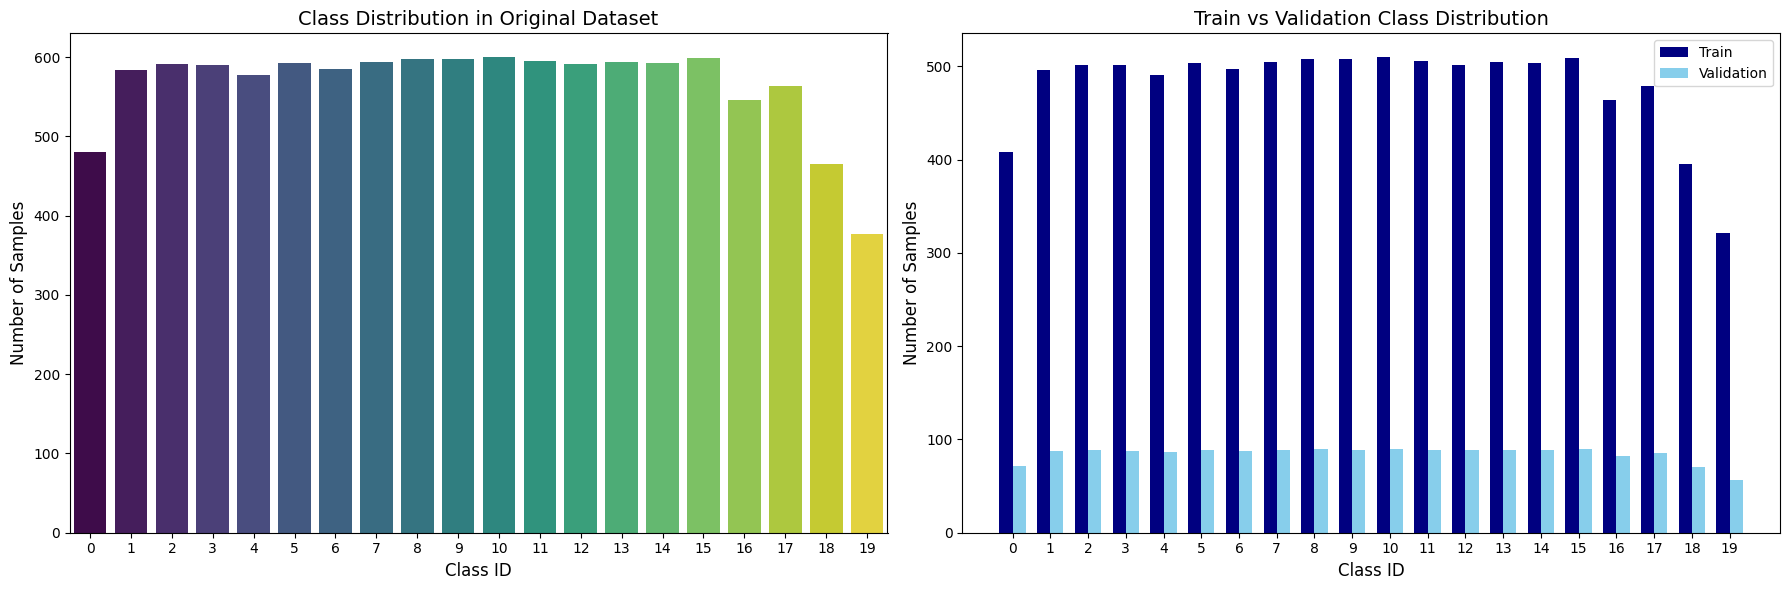

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Determine number of target classes from original training labels
original_classes, original_counts = np.unique(train_data.target, return_counts=True)
NUM_CLASS = len(original_counts)

# Compute class distributions for training and validation splits
train_classes, train_counts = np.unique(y_train, return_counts=True)
val_classes, val_counts = np.unique(y_val, return_counts=True)

# Set up subplots: (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot class distribution for original dataset
sns.barplot(
    x=original_classes,
    y=original_counts,
    ax=ax1,
    hue=original_classes,
    palette='viridis',
    legend=False
)
ax1.set_title('Class Distribution in Original Dataset', fontsize=14)
ax1.set_xlabel('Class ID', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_xticks(original_classes)

# Plot side-by-side bar chart for train and validation splits
bar_width = 0.35
x_pos = np.arange(len(train_classes))

ax2.bar(x_pos - bar_width / 2, train_counts, width=bar_width, label='Train', color='navy')
ax2.bar(x_pos + bar_width / 2, val_counts, width=bar_width, label='Validation', color='skyblue')

ax2.set_title('Train vs Validation Class Distribution', fontsize=14)
ax2.set_xlabel('Class ID', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(train_classes)
ax2.legend()

# Adjust spacing between plots and display
plt.tight_layout()
plt.show()


Design the Encoder of the transformer model from scratch using PyTorch (i.e. using torch functions and torch layers) to perform classification on this dataset. You are not allowed to use the pytorch multi head attention layer.
Use the following hyper-parameters:
<li>d_model = 32</li>
<li>num_heads = 4</li>
<li>num_enc_layers = 4</li>
<li>d_ff = 128</li>
<li>dropout = 0.1</li>

**Note:** The output from the encoder needs to be max-pooled and then passed to the classifier

In [ ]:
# Import essential PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

# ---------------------------
# Hyperparameters
# ---------------------------
D_MODEL = 32           # Embedding dimension
NUM_HEADS = 4          # Number of attention heads
NUM_ENC_LAYERS = 4     # Number of transformer encoder layers
D_FF = 128             # Dimension of feedforward layer
DROPOUT = 0.1          # Dropout rate


# ---------------------------
# Multi-Head Self-Attention Layer
# ---------------------------
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout):
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads
    self.dropout_p = dropout

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_o = nn.Linear(d_model, d_model)

  def forward(self, x, mask=None):
    batch_size, seq_len, _ = x.size()

    # Linear projections and reshape for multi-head attention
    q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
    k = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
    v = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

    # Scaled Dot-Product Attention
    attn_output = F.scaled_dot_product_attention(
        q, k, v,
        attn_mask=mask,
        dropout_p=self.dropout_p if self.training else 0
    )

    # Concatenate heads
    attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
    return self.w_o(attn_output)

# ---------------------------
# Feedforward block within Transformer
# ---------------------------
class PositionWiseFFN(nn.Module):
  def __init__(self, d_model, d_ff, dropout):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.linear2(self.dropout(F.relu(self.linear1(x))))

# ---------------------------
# Single Transformer Encoder Layer
# ---------------------------
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super().__init__()
    self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
    self.ffn = PositionWiseFFN(d_model, d_ff, dropout)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)

  def forward(self, x, mask=None):
    x = x + self.dropout1(self.self_attn(self.norm1(x), mask))
    x = x + self.dropout2(self.ffn(self.norm2(x)))
    return x
# ---------------------------
# Transformer Encoder with Positional Embeddings
# ---------------------------
class TransformerEncoder(nn.Module):
  def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, dropout):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
    self.pos_embedding = nn.Embedding(150, d_model)  # Max sequence length assumed to be 150
    self.layers = nn.ModuleList([
        EncoderLayer(d_model, num_heads, d_ff, dropout)
        for _ in range(num_layers)
    ])
    self.scale = torch.sqrt(torch.FloatTensor([d_model]))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    batch_size, seq_len = x.size()
    positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
    mask = (x != 0).unsqueeze(1).unsqueeze(2)  # Mask to ignore padding tokens

    x = self.embedding(x) * self.scale.to(x.device) + self.pos_embedding(positions)
    x = self.dropout(x)

    for layer in self.layers:
        x = layer(x, mask)

    # Aggregate sequence information using max pooling
    return x.max(dim=1)[0]

# ---------------------------
# Complete Classification Model using Transformer Encoder
# ---------------------------
class NewsClassifier(nn.Module):
  def __init__(self, vocab_size, d_model=D_MODEL, num_heads=NUM_HEADS, num_layers=NUM_ENC_LAYERS, d_ff=D_FF, dropout=DROPOUT, num_classes=NUM_CLASS):
    super().__init__()
    self.encoder = TransformerEncoder(
        vocab_size, d_model, num_heads, num_layers, d_ff, dropout
    )
    self.classifier = nn.Linear(d_model, num_classes)

  def forward(self, x):
    encoded = self.encoder(x)
    return self.classifier(encoded)

# Training configuration
BATCH_SIZE = 256
LR = 3e-4

# ---------------------------
# Model Initialization
# ---------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NewsClassifier(
    vocab_size=len(word_index) + 1,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_ENC_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT
).to(device)

# Loss and optimizer setup
criterion = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR)

# Compile model for faster training (PyTorch 2.0+)
model = torch.compile(model)

# Print model summary
print("\nModel architecture:\n")
print(model)



Model architecture:

OptimizedModule(
  (_orig_mod): NewsClassifier(
    (encoder): TransformerEncoder(
      (embedding): Embedding(129447, 32, padding_idx=0)
      (pos_embedding): Embedding(150, 32)
      (layers): ModuleList(
        (0-3): 4 x EncoderLayer(
          (self_attn): MultiHeadAttention(
            (w_q): Linear(in_features=32, out_features=32, bias=True)
            (w_k): Linear(in_features=32, out_features=32, bias=True)
            (w_v): Linear(in_features=32, out_features=32, bias=True)
            (w_o): Linear(in_features=32, out_features=32, bias=True)
          )
          (ffn): PositionWiseFFN(
            (linear1): Linear(in_features=32, out_features=128, bias=True)
            (linear2): Linear(in_features=128, out_features=32, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        


Train the model using a suitable loss function and the AdamW optimizer with the following hyper-parameters
<li>num_epochs = 100</li>
<li>batch_size = 256/128</li>
<li>lr=0.0003</li>
Save the model having the lowest validation loss.

In [ ]:
# Number of subprocesses to use for data loading
NUM_WORKER = 2

# Convert input features and labels to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.LongTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

# Wrap tensors into TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# DataLoader for training set
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,              # Shuffle for training
    pin_memory=True,           # Faster transfer to GPU
    num_workers=NUM_WORKER,    # Number of background threads
    persistent_workers=True    # Keep workers alive for faster loading
)

# DataLoader for validation set
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,             # No shuffling for validation
    pin_memory=True,
    num_workers=NUM_WORKER,
    persistent_workers=True
)


In [ ]:
# Training hyperparameters
NUM_EPOCH = 100
PATIENCE = 10  # Max number of epochs without improvement before stopping

# Function to train the model
def train_model(model, train_loader, val_loader, optimizer, criterion, device,v='v1',patience=PATIENCE):
  scaler = torch.amp.GradScaler()
  best_val_loss = float('inf')
  epochs_no_improve = 0
  train_losses = []
  val_losses = []
  early_stop = False

  for epoch in range(NUM_EPOCH):
    if early_stop:
      break

    model.train()
    running_train_loss = 0.0

    # --- Training Loop ---
    for inputs, labels in train_loader:
      inputs = inputs.to(device, non_blocking=True)
      labels = labels.to(device, non_blocking=True)

      optimizer.zero_grad()

      # Mixed precision training
      with torch.amp.autocast(device_type='cuda', enabled=True, dtype=torch.float16):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      running_train_loss += loss.item() * inputs.size(0)

    # --- Validation Loop ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item() * inputs.size(0)

    # Compute average losses
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    # --- Early Stopping Logic ---
    if epoch_val_loss < best_val_loss:
      best_val_loss = epoch_val_loss
      torch.save(model.state_dict(), 'best_model_'+v+'.pth')
      epochs_no_improve = 0
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered. No improvement for 10 consecutive epochs.")
        early_stop = True

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
      print(f"[Epoch {epoch+1}/{NUM_EPOCH}]")
      print(f"Train Loss: {epoch_train_loss:.4f} | Validation Loss: {epoch_val_loss:.4f}")
      #print(f"Patience Counter: {epochs_no_improve}/{patience}")
      print("-" * 50)

  print("Training process completed.")

  return train_losses, val_losses

In [ ]:
# --- Call the training function ---
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, device)


[Epoch 5/100]
Train Loss: 3.6360 | Validation Loss: 3.4568
--------------------------------------------------
[Epoch 10/100]
Train Loss: 3.2450 | Validation Loss: 3.1042
--------------------------------------------------
[Epoch 15/100]
Train Loss: 2.8892 | Validation Loss: 2.8045
--------------------------------------------------
[Epoch 20/100]
Train Loss: 2.4571 | Validation Loss: 2.4375
--------------------------------------------------
[Epoch 25/100]
Train Loss: 1.9001 | Validation Loss: 1.9483
--------------------------------------------------
[Epoch 30/100]
Train Loss: 1.4696 | Validation Loss: 1.6073
--------------------------------------------------
[Epoch 35/100]
Train Loss: 1.1586 | Validation Loss: 1.4014
--------------------------------------------------
[Epoch 40/100]
Train Loss: 0.9383 | Validation Loss: 1.2560
--------------------------------------------------
[Epoch 45/100]
Train Loss: 0.7753 | Validation Loss: 1.1625
--------------------------------------------------
[E

Perform prediction on the train, validation and test sets. Plot the train and validation losses. Report the accuracy, precision and confusion matrix on all three dataset partitions.

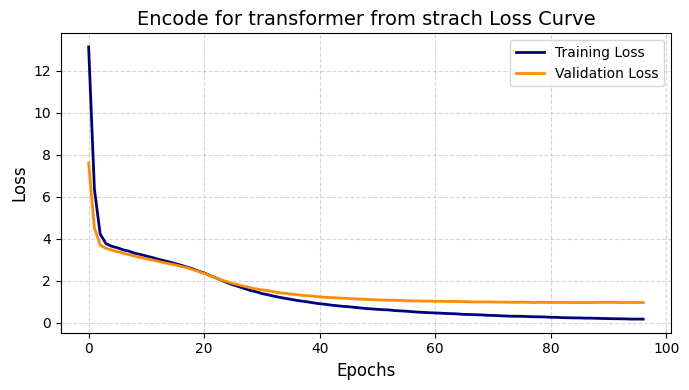


Training Encoder Set Metrics:
  ➤ Accuracy       : 0.9882
  ➤ Macro Precision: 0.9883


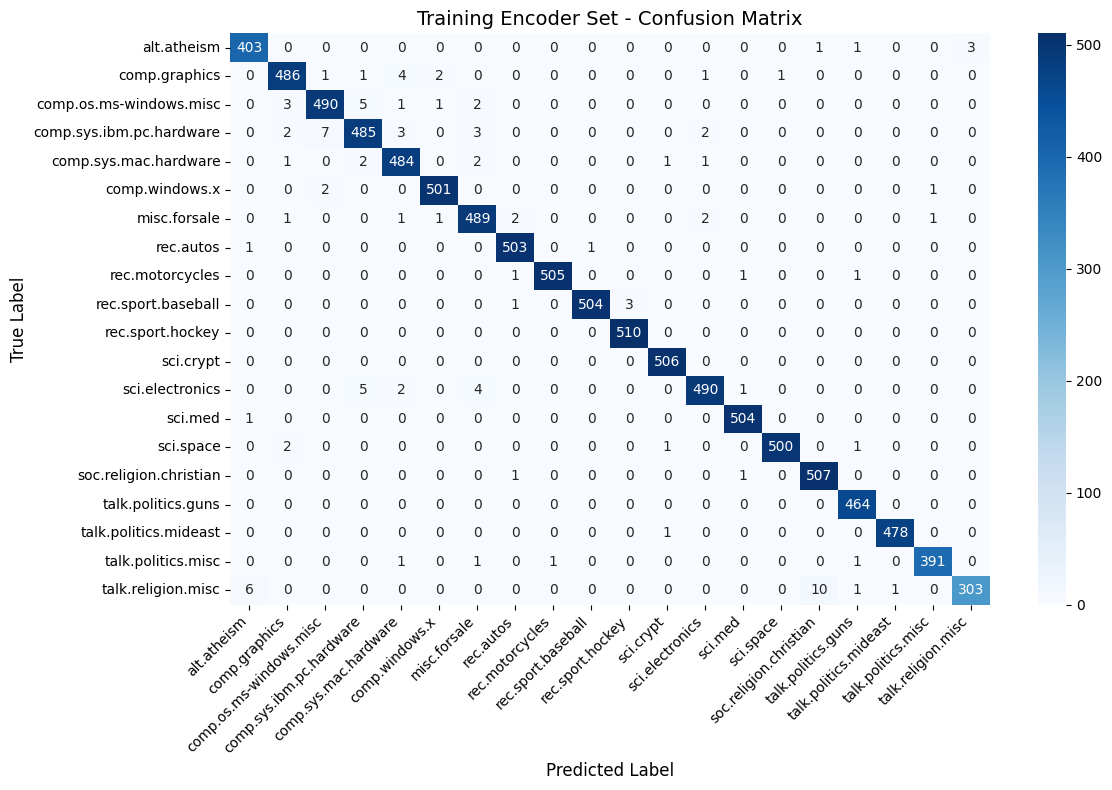


Validation Encoder Set Metrics:
  ➤ Accuracy       : 0.7562
  ➤ Macro Precision: 0.7577


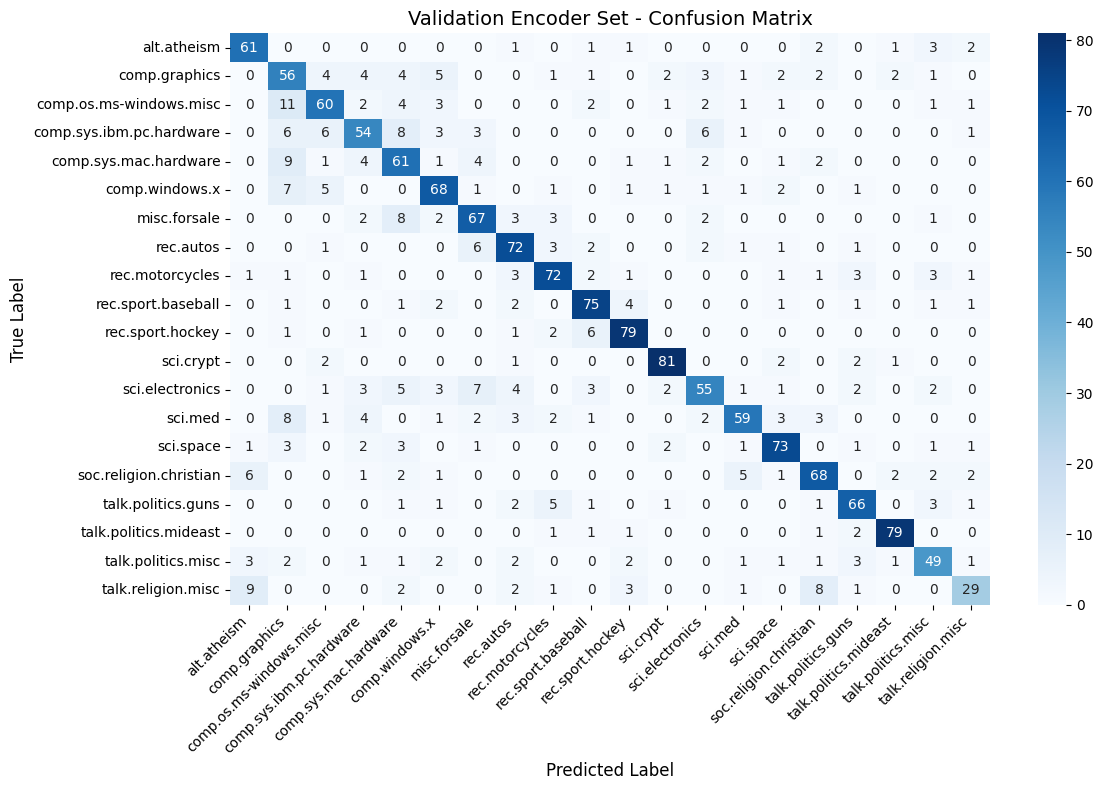


Test Encoder Set Metrics:
  ➤ Accuracy       : 0.6210
  ➤ Macro Precision: 0.6389


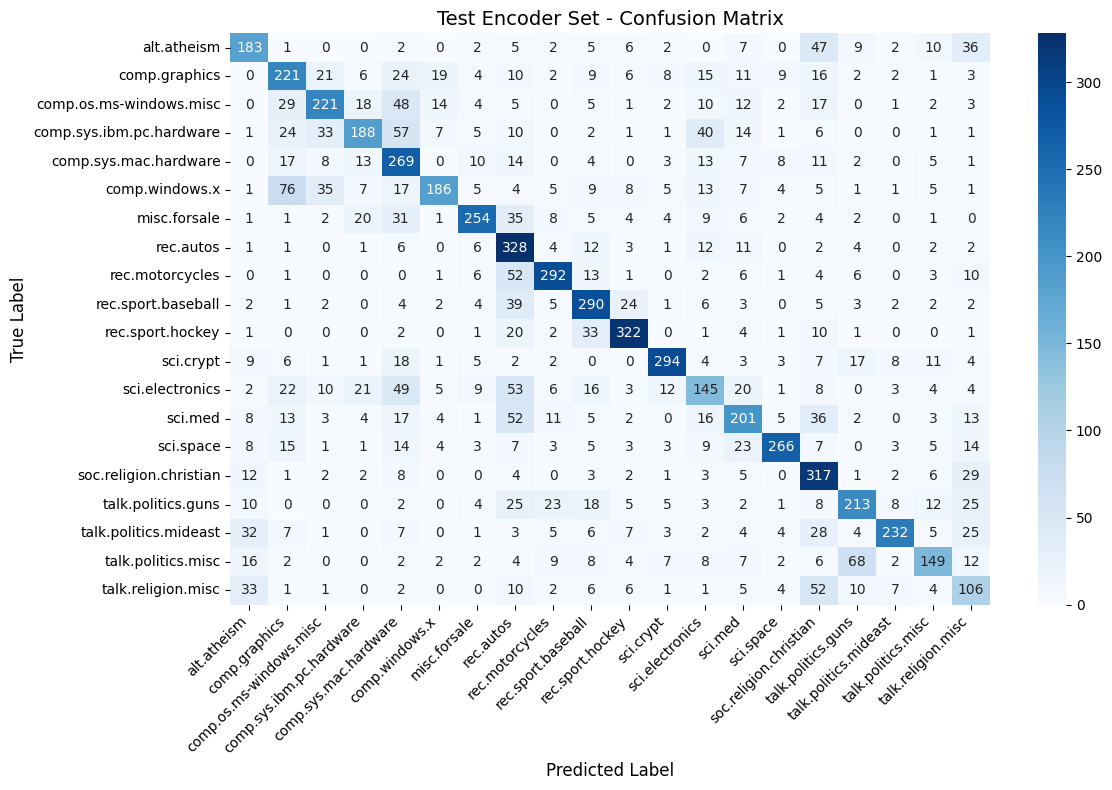

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# --- Preprocess Test Set ---
preprocessed_test = [' '.join(preprocess_text(text)) for text in test_data.data]
test_sequences = tokenizer.texts_to_sequences(preprocessed_test)
X_test = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y_test = test_data.target

# Convert to TensorDataset and DataLoader
test_dataset = TensorDataset(torch.LongTensor(X_test), torch.LongTensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------
# Visualize Training Progress
# -------------------------------
def plot_loss_curve(train_losses, val_losses, title="Loss Curve"):
  plt.figure(figsize=(7, 4))
  plt.plot(train_losses, label='Training Loss', color='navy', linewidth=2)
  plt.plot(val_losses, label='Validation Loss', color='darkorange', linewidth=2)
  plt.title(title, fontsize=14)
  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.legend()
  plt.tight_layout()
  plt.show()


# --- Evaluation Function ---
def evaluate(model, dataloader):
  model.eval()
  all_preds, all_labels = [], []

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      predictions = torch.argmax(outputs, dim=1)
      all_preds.extend(predictions.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  return all_labels, all_preds


# --- Metrics & Confusion Matrix Visualization ---
def print_metrics(title, true_labels, predictions):
  acc = accuracy_score(true_labels, predictions)
  macro_prec = precision_score(true_labels, predictions, average='macro',zero_division=0)
  cm = confusion_matrix(true_labels, predictions)

  print(f"\n{title} Set Metrics:")
  print(f"  ➤ Accuracy       : {acc:.4f}")
  print(f"  ➤ Macro Precision: {macro_prec:.4f}")

  plt.figure(figsize=(12, 8))
  sns.heatmap(cm, annot=True,fmt='d', cmap='Blues',xticklabels=train_data.target_names,yticklabels=train_data.target_names)
  plt.title(f"{title} Set - Confusion Matrix", fontsize=14)
  plt.xlabel("Predicted Label", fontsize=12)
  plt.ylabel("True Label", fontsize=12)
  plt.xticks(rotation=45, ha='right')
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.show()



# Plot the loss trends for model
plot_loss_curve(train_losses, val_losses, title="Encode for transformer from strach Loss Curve")


# --- Load Best Model ---
model.load_state_dict(torch.load('best_model_v1.pth'))

# --- Evaluate Across All Sets ---
print_metrics("Training Encoder", *evaluate(model, train_loader))
print_metrics("Validation Encoder", *evaluate(model, val_loader))
print_metrics("Test Encoder", *evaluate(model, test_loader))

Redesign the encoder model using nn.MultiHeadAttention() layers and train it using the same cost function and optimizer. Plot the train and validation losses. Report the accuracy, precision and confusion matrix on all three dataset partitions.

Use the same hyper-parameters.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

# ---------------------------
# Feedforward Network Block
# ---------------------------
class PositionWiseFFN(nn.Module):
  def __init__(self, d_model, d_ff, dropout):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = self.dropout(x)
    return self.linear2(x)

# ---------------------------
# Transformer Encoder Layer
# ---------------------------
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super().__init__()
    self.self_attn = nn.MultiheadAttention(
      embed_dim=d_model,
      num_heads=num_heads,
      dropout=dropout,
      batch_first=True
    )
    self.ffn = PositionWiseFFN(d_model, d_ff, dropout)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)

  def forward(self, x, key_padding_mask=None):
    # Multi-head Self-Attention with residual connection
    residual = x
    x_norm = self.norm1(x)
    attn_output, _ = self.self_attn(
        query=x_norm,
        key=x_norm,
        value=x_norm,
        key_padding_mask=key_padding_mask
    )
    x = residual + self.dropout1(attn_output)

    # Feedforward layer with residual connection
    ffn_output = self.ffn(self.norm2(x))
    x = x + self.dropout2(ffn_output)
    return x

# ---------------------------
# Transformer Encoder Stack
# ---------------------------
class TransformerEncoder(nn.Module):
  def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, dropout, max_len=150):
    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
    self.position_embedding = nn.Embedding(max_len, d_model)
    self.encoder_layers = nn.ModuleList([
        EncoderLayer(d_model, num_heads, d_ff, dropout)
        for _ in range(num_layers)
    ])
    self.dropout = nn.Dropout(dropout)
    self.scale = torch.sqrt(torch.tensor(d_model, dtype=torch.float32))

  def forward(self, x):
    batch_size, seq_len = x.size()
    positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
    key_padding_mask = (x == 0)  # True for PAD tokens

    # Token and positional embeddings
    x = self.token_embedding(x) * self.scale.to(x.device)
    x = x + self.position_embedding(positions)
    x = self.dropout(x)

    # Pass through each Transformer encoder layer
    for layer in self.encoder_layers:
        x = layer(x, key_padding_mask=key_padding_mask)

    # Aggregate sequence representation using max pooling
    return x.max(dim=1)[0]

# ---------------------------
# Full Transformer Classifier
# ---------------------------
class NewsClassifier(nn.Module):
  def __init__(self, vocab_size, d_model=32, num_heads=4,
              num_layers=4, d_ff=128, dropout=0.1, num_classes=20):
    super().__init__()
    self.encoder = TransformerEncoder(
        vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff,
        dropout=dropout
    )
    self.classifier = nn.Linear(d_model, num_classes)

  def forward(self, x):
    encoded_output = self.encoder(x)
    return self.classifier(encoded_output)

# ---------------------------
# Model Initialization
# ---------------------------
model_v2 = NewsClassifier(
  vocab_size=len(word_index) + 1,
  d_model=D_MODEL,
  num_heads=NUM_HEADS,
  num_layers=NUM_ENC_LAYERS,
  d_ff=D_FF,
  dropout=DROPOUT,
  num_classes=20
).to(device)

# Optimizer setup
optimizer = AdamW(model_v2.parameters(), lr=LR)

# Enable model compilation for performance
model_v2 = torch.compile(model_v2)

# Print model summary
print(model_v2)


OptimizedModule(
  (_orig_mod): NewsClassifier(
    (encoder): TransformerEncoder(
      (token_embedding): Embedding(129447, 32, padding_idx=0)
      (position_embedding): Embedding(150, 32)
      (encoder_layers): ModuleList(
        (0-3): 4 x EncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (ffn): PositionWiseFFN(
            (linear1): Linear(in_features=32, out_features=128, bias=True)
            (linear2): Linear(in_features=128, out_features=32, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (classifier)

In [ ]:
# --- Call the training function ---
train_losses_v2, val_losses_v2 = train_model(model_v2, train_loader, val_loader, optimizer, criterion, device,'v2')


[Epoch 5/100]
Train Loss: 3.6790 | Validation Loss: 3.4478
--------------------------------------------------
[Epoch 10/100]
Train Loss: 3.1978 | Validation Loss: 3.0459
--------------------------------------------------
[Epoch 15/100]
Train Loss: 2.7007 | Validation Loss: 2.6613
--------------------------------------------------
[Epoch 20/100]
Train Loss: 2.1794 | Validation Loss: 2.2219
--------------------------------------------------
[Epoch 25/100]
Train Loss: 1.7439 | Validation Loss: 1.8663
--------------------------------------------------
[Epoch 30/100]
Train Loss: 1.4064 | Validation Loss: 1.6029
--------------------------------------------------
[Epoch 35/100]
Train Loss: 1.1410 | Validation Loss: 1.3934
--------------------------------------------------
[Epoch 40/100]
Train Loss: 0.9454 | Validation Loss: 1.2674
--------------------------------------------------
[Epoch 45/100]
Train Loss: 0.7968 | Validation Loss: 1.1855
--------------------------------------------------
[E

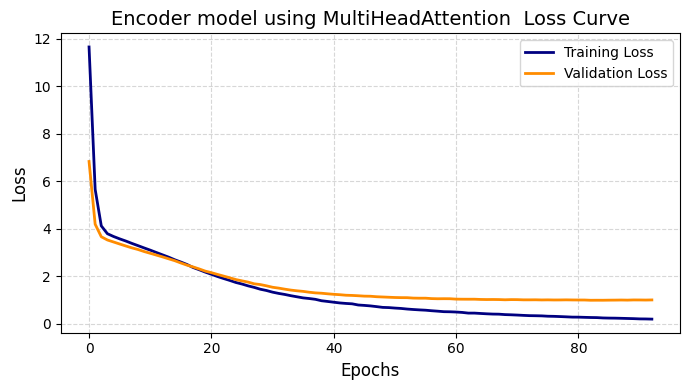


Training  Encoder) Set Metrics:
  ➤ Accuracy       : 0.9799
  ➤ Macro Precision: 0.9802


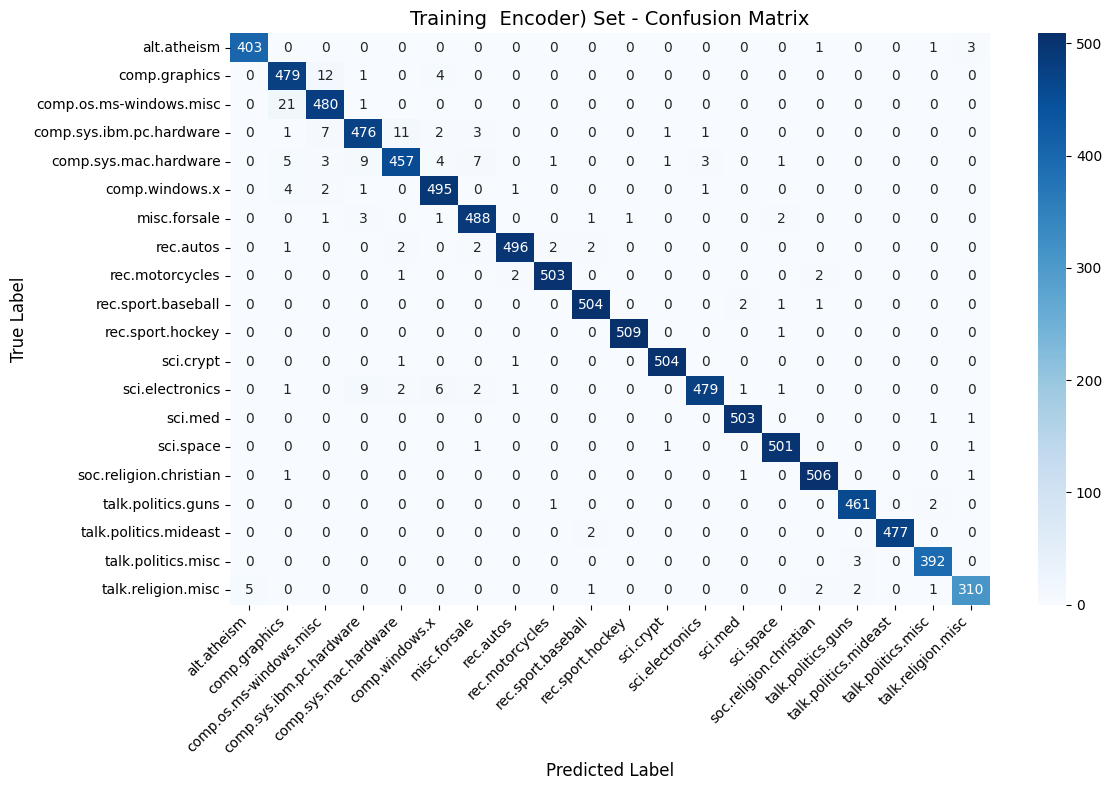


Validation Encoder) Set Metrics:
  ➤ Accuracy       : 0.7456
  ➤ Macro Precision: 0.7471


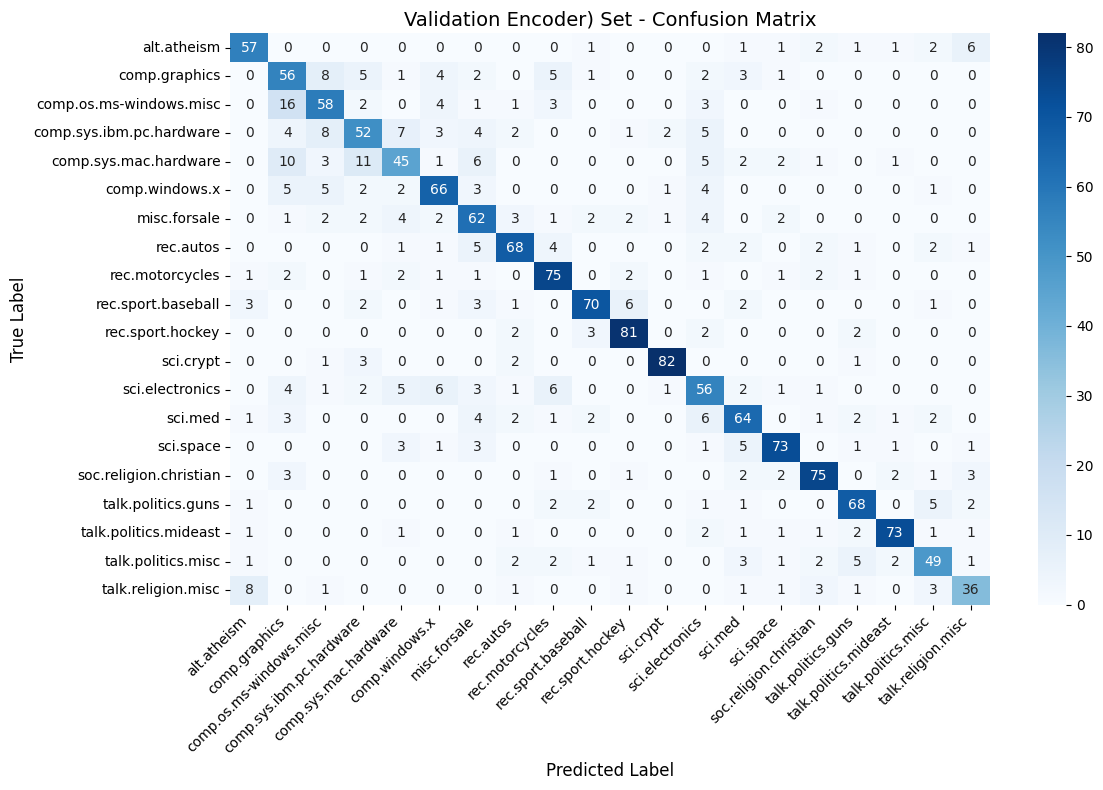


Test Encoder) Set Metrics:
  ➤ Accuracy       : 0.6239
  ➤ Macro Precision: 0.6345


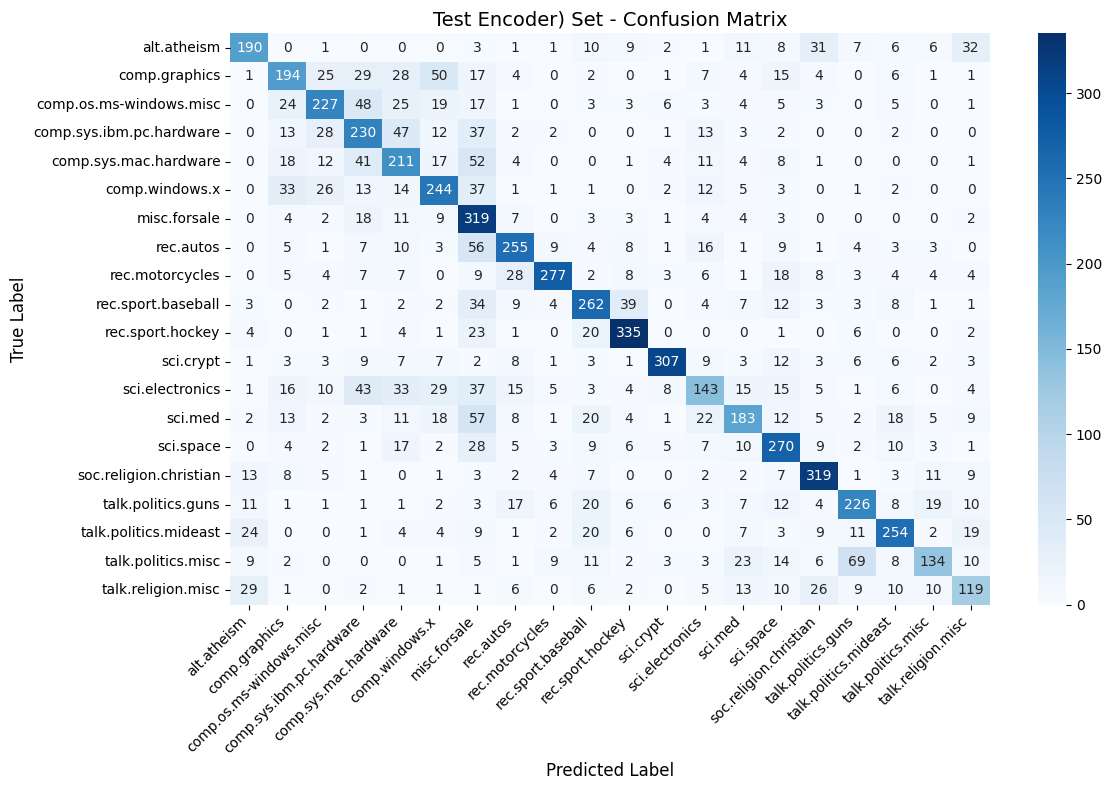

In [ ]:
# -------------------------------
# Visualize Training Progress
# -------------------------------

# Plot the loss trends for model_v2
plot_loss_curve(train_losses_v2, val_losses_v2, title="Encoder model using MultiHeadAttention  Loss Curve")

# Load Best Model Checkpoint
model_v2.load_state_dict(torch.load('best_model_v2.pth'))

# Evaluate Model on All Partitions
print_metrics("Training  Encoder)", *evaluate(model_v2, train_loader))
print_metrics("Validation Encoder)", *evaluate(model_v2, val_loader))
print_metrics("Test Encoder)", *evaluate(model_v2, test_loader))


Finally design the model using the nn.TransformerEncoder() and train it using the same hyper-paramters

In [ ]:
import torch
import torch.nn as nn
import math

# ================== POSITIONAL ENCODING ==================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=150):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ================== TRANSFORMER CLASSIFIER ==================
class TransformerClassifier(nn.Module):
  def __init__(self, vocab_size, d_model=32, num_heads=4,
              num_layers=4, d_ff=128, dropout=0.1, num_classes=20):
      super().__init__()

      # Embedding layer with proper initialization
      self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
      self.pos_encoder = PositionalEncoding(d_model)
      self.dropout = nn.Dropout(dropout)
      self.scale = math.sqrt(d_model)

      # Transformer encoder configuration
      encoder_layer = nn.TransformerEncoderLayer(
          d_model=d_model,
          nhead=num_heads,
          dim_feedforward=d_ff,
          dropout=dropout,
          activation='gelu',
          batch_first=True
      )
      self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

      # Classifier with proper initialization
      self.classifier = nn.Linear(d_model, num_classes)
      self._init_weights()

  def _init_weights(self):
    #weight initialization
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    nn.init.normal_(self.embedding.weight, mean=0, std=self.scale**-0.5)
    nn.init.constant_(self.classifier.bias, 0)
    nn.init.xavier_uniform_(self.classifier.weight)

  def forward(self, x):
    # padding mask
    src_key_padding_mask = (x == 0)

    # Embedding with scaling
    x = self.embedding(x) * self.scale
    x = self.pos_encoder(x)
    x = self.dropout(x)

    # Transformer encoder
    x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)

    # Max pooling with mask consideration
    x = x.masked_fill(src_key_padding_mask.unsqueeze(-1), -float('inf')).max(dim=1)[0]

    return self.classifier(x)


# ----------------------------------------
# Instantiate and Compile Transformer v3
# ----------------------------------------

model_v3 = TransformerClassifier(
  vocab_size=len(word_index) + 1,  # Including padding token
  d_model=D_MODEL,
  num_heads=NUM_HEADS,
  num_layers=NUM_ENC_LAYERS,
  d_ff=D_FF,
  dropout=DROPOUT
).to(device)

# Define optimize and loss function
optimizer = AdamW(model_v3.parameters(), lr=LR)
criterion = CrossEntropyLoss()

# Compile the model for performance boost (requires PyTorch 2.0+)
model_v3 = torch.compile(model_v3)

# Model summary
print(model_v3)

OptimizedModule(
  (_orig_mod): TransformerClassifier(
    (embedding): Embedding(129447, 32, padding_idx=0)
    (pos_encoder): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (classifier): Linear(in_features=32, out_features=20, bias=True)
  

In [ ]:
# --- Call the training function ---
train_losses_v3, val_losses_v3 = train_model(model_v3, train_loader, val_loader, optimizer, criterion, device,'v3',50)


[Epoch 5/100]
Train Loss: 2.9898 | Validation Loss: 3.0780
--------------------------------------------------
[Epoch 10/100]
Train Loss: 2.8551 | Validation Loss: 2.7767
--------------------------------------------------
[Epoch 15/100]
Train Loss: 2.1624 | Validation Loss: 2.0967
--------------------------------------------------
[Epoch 20/100]
Train Loss: 1.5131 | Validation Loss: 1.5969
--------------------------------------------------
[Epoch 25/100]
Train Loss: 1.0901 | Validation Loss: 1.3080
--------------------------------------------------
[Epoch 30/100]
Train Loss: 0.7724 | Validation Loss: 1.1378
--------------------------------------------------
[Epoch 35/100]
Train Loss: 0.5649 | Validation Loss: 1.0422
--------------------------------------------------
[Epoch 40/100]
Train Loss: 0.4098 | Validation Loss: 0.9848
--------------------------------------------------
[Epoch 45/100]
Train Loss: 0.2984 | Validation Loss: 0.9444
--------------------------------------------------
[E

Plot the train and validation losses. Report the accuracy, precision and confusion matrix on all three dataset partitions.

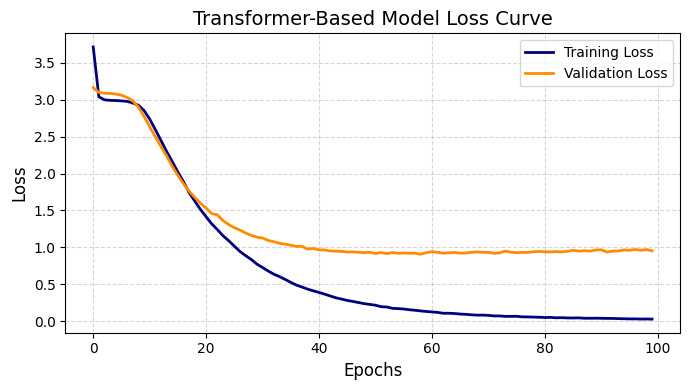


Training (Official Encoder) Set Metrics:
  ➤ Accuracy       : 0.9928
  ➤ Macro Precision: 0.9930


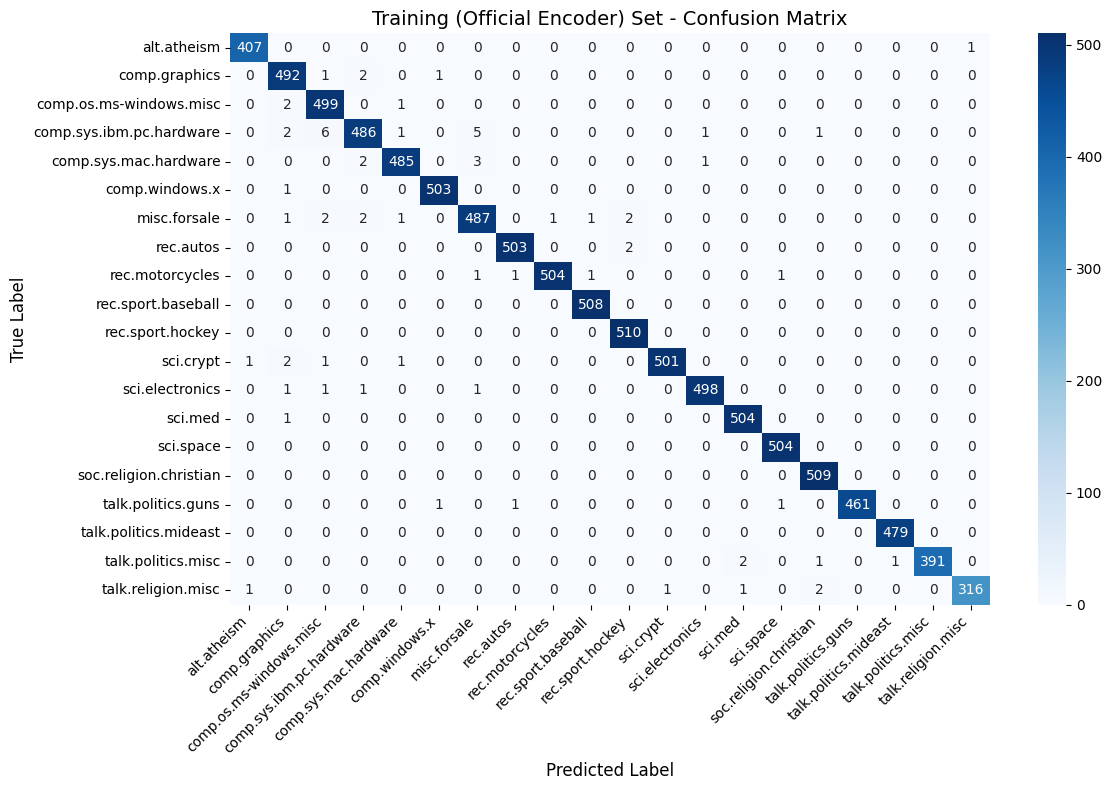


Validation (Official Encoder) Set Metrics:
  ➤ Accuracy       : 0.7915
  ➤ Macro Precision: 0.7952


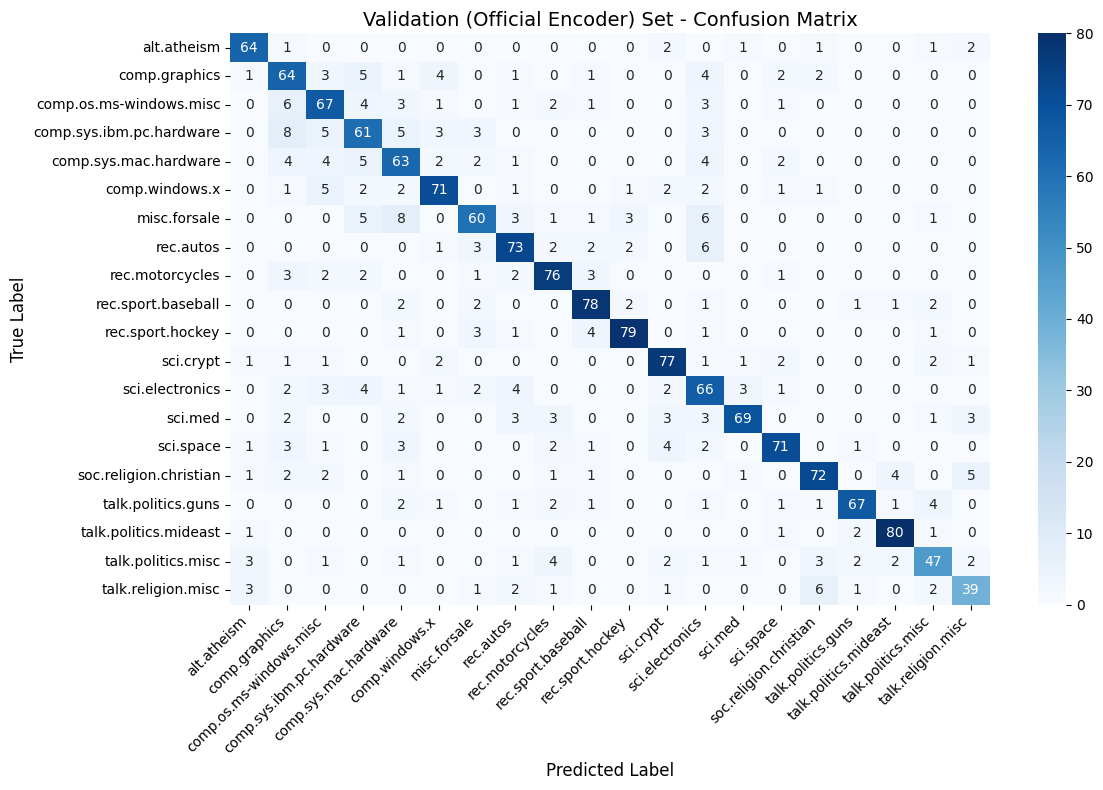


Test (Official Encoder) Set Metrics:
  ➤ Accuracy       : 0.6313
  ➤ Macro Precision: 0.6316


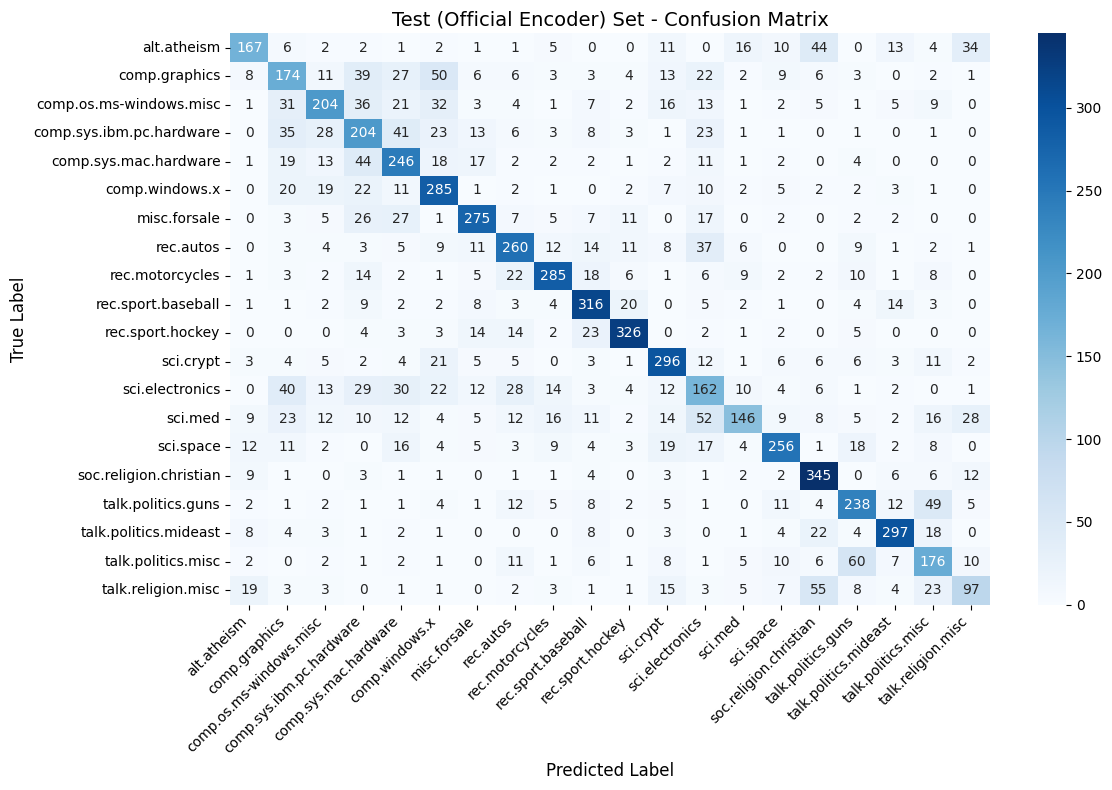

In [ ]:
# -------------------------------
# Visualize Training Progress
# -------------------------------

plot_loss_curve(train_losses_v3, val_losses_v3, title="Transformer-Based Model Loss Curve")

# Load Best Model Checkpoint
model_v3.load_state_dict(torch.load('best_model_v3.pth'))

# Evaluate Model on All Partitions
print_metrics("Training (Official Encoder)", *evaluate(model_v3, train_loader))
print_metrics("Validation (Official Encoder)", *evaluate(model_v3, val_loader))
print_metrics("Test (Official Encoder)", *evaluate(model_v3, test_loader))